In [1]:
import torch
import torchvision
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
import cv2
import imgaug.augmenters as iaa
from cardiac_dataset import CardiacDataset
from PIL import Image

C:\Users\admin\Documents\GitHub\Heart-Detection-PyTorch\venv\Lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [2]:
train_root_path = 'Processed-Heart-Detection/train'
train_subjects = 'Processed-Heart-Detection/train_subjects.npy'

val_root_path = 'Processed-Heart-Detection/val'
val_subjects = 'Processed-Heart-Detection/val_subjects.npy'

train_transforms = iaa.Sequential([
    iaa.GammaContrast(),
    iaa.Affine(
        scale=(0.8, 1.2),
        rotate=(-10, 10),
        translate_px=(-10, 10))
])

In [3]:
train_dataset = CardiacDataset('Dataset/rsna_heart_detection.csv', train_subjects, train_root_path, train_transforms)
val_dataset = CardiacDataset('Dataset/rsna_heart_detection.csv', val_subjects, val_root_path, None)

In [4]:
batch_size = 8
num_workers = 0

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

In [5]:
class CardiacDetectionModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        # pretrained=True makes PyTorch load the resnet18 model with predefined weights
        self.model = torchvision.models.resnet18(pretrained=True)
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.model.fc = torch.nn.Linear(in_features=512, out_features=4)

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = torch.nn.MSELoss()

    def forward(self, data):
        return self.model(data)

    def training_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)
        loss = self.loss_fn(pred, label)

        self.log('Train Loss', loss)

        if batch_idx % 50 == 0:
            self.log_images(x_ray.cpu(), pred.cpu(), label.cpu(), 'Train')

        return loss

    def validation_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)
        loss = self.loss_fn(pred, label)

        self.log('Val Loss', loss)

        if batch_idx % 50 == 0:
            self.log_images(x_ray.cpu(), pred.cpu(), label.cpu(), 'Val')

        return loss

    # This is only for visualization in tensorboard and is not needed for the actual training
    def log_images(self, x_ray, pred, label, name):
        results = []

        for i in range(4):
            # Label is a tensor and each 'i' gives us 4 points
            coords_labels = label[i]
            coords_pred = pred[i]
            # un-normalize and transforming into numpy array, also removing batch layer
            img = ((x_ray[i] * 0.252) + 0.494).numpy()[0]

            # Drawing a black rectangle around actual points
            x0, y0 = coords_labels[0].int().item(), coords_labels[1].int().item()
            x1, y1 = coords_labels[2].int().item(), coords_labels[3].int().item()
            img = cv2.rectangle(img, (x0, y0), (x1, y1), (0, 0, 0), 2)

            # Drawing a white rectangle around predicted points
            x0, y0 = coords_pred[0].int().item(), coords_pred[1].int().item()
            x1, y1 = coords_pred[2].int().item(), coords_pred[3].int().item()
            img = cv2.rectangle(img, (x0, y0), (x1, y1), (1, 1, 1), 2)

            # Adding batch layer to img and transforming it to tensor
            # then appending it to result list
            results.append(torch.tensor(img).unsqueeze(0))
            
            # Convert numpy array to PIL Image
            pil_img = Image.fromarray((img * 255).astype('uint8'))
    
            # Save the PIL Image
            pil_img.save(f"gifs/{name}_img_{self.global_step}_{i}.png")

        # Makes a grid from the list of 4 processed images
        # The grid will have 2 columns
        grid = torchvision.utils.make_grid(results, 2)
        self.logger.experiment.add_image(name, grid, self.global_step)
 
    
    def configure_optimizers(self):
        return [self.optimizer]

In [6]:
model = CardiacDetectionModel()

C:\Users\admin\Documents\GitHub\Heart-Detection-PyTorch\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\admin\Documents\GitHub\Heart-Detection-PyTorch\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
# Saving the top10 best models
checkpoint_callback = ModelCheckpoint(
    monitor='Val Loss',
    save_top_k=10,
    mode='min',
)

In [8]:
# Where and how to save the models
trainer = pl.Trainer(logger=TensorBoardLogger(save_dir='./logs'), log_every_n_steps=1,
                     callbacks=checkpoint_callback, max_epochs=100)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, train_loader, val_loader)

In [10]:
# Load and evaluate model
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = CardiacDetectionModel.load_from_checkpoint('logs/lightning_logs/version_0/checkpoints/epoch=99-step=5000.ckpt')
model.eval();
model.to(device)

C:\Users\admin\Documents\GitHub\Heart-Detection-PyTorch\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\admin\Documents\GitHub\Heart-Detection-PyTorch\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


CardiacDetectionModel(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tru

In [11]:
preds = []
labels = []

with torch.no_grad():
    for data, label in (val_dataset):
        # unsqueeze(0) adds a batch axis in front of all axis
        data = data.to(device).float().unsqueeze(0)
        # Remove channel batch dimension and move the data to cpu
        pred = model(data)[0].cpu()
        preds.append(pred)
        labels.append(label)

preds = torch.stack(preds)
labels = torch.stack(labels).int()

In [12]:
# Mean difference between Coords x0,x1,y0,y1
# We are only 4-5 pixels off, which is very good
abs(preds - labels).mean(0)

tensor([5.8801, 4.1603, 3.9531, 4.4907])

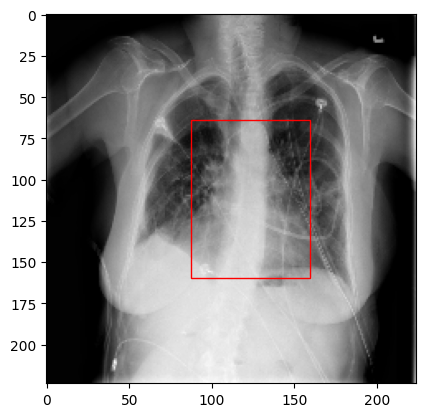

In [13]:
IDX = 0
img, label = val_dataset[IDX]
pred = preds[IDX]

fig, axis = plt.subplots(1, 1)
axis.imshow(img[0], cmap='gray')
heart = patches.Rectangle((pred[0], pred[1]), pred[2] - pred[0], pred[3] - pred[1], edgecolor='r', facecolor='none')
axis.add_patch(heart)